In [1]:
from sklearn.datasets import make_regression, load_boston
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler

In [2]:
def cubic_polynomial(x, y, noise=0.1):
    z = (x-y)**3
    z += np.random.uniform(low=-noise*z, high=noise*z)
    return z

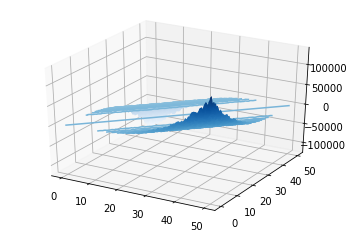

In [3]:
xline = np.linspace(0, 50, 100)
yline = np.linspace(0, 50, 100)
X, Y = np.meshgrid(xline, yline)
zline = cubic_polynomial(X, Y)
ax1 = plt.axes(projection='3d')
ax1.contour3D(X, Y, zline, 200, cmap='Blues')

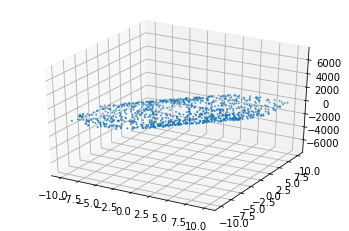

In [4]:
x = np.random.uniform(low=-10, high=10, size=1000)
y = np.random.uniform(low=-10, high=10, size=1000)
z = cubic_polynomial(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, marker='o', s=1)

In [5]:
X = np.vstack((x, y)).T
y = z
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [6]:
def gaussian_kernel(x1, x2, gamma):
    return np.exp(-gamma * LA.norm(x1-x2, axis=-1)**2)

def poly_kernel(x1, x2, degree=3, r=1, gamma=1):
    return (np.dot(x1, x2.T) * gamma + r) ** degree

def laplacian_kernel(x1, x2, gamma):
    return np.exp(-gamma * LA.norm(x1-x2, axis=-1, ord=1))

In [12]:
class svr:
    def __init__(self, gamma=1, degree=3, r=2, kernel="rbf"):
        self.gamma = gamma
        self.degree = degree
        self.r = r
        self.kernel = kernel
        
    def _kernel_function(self, x1, x2):
        if self.kernel == "rbf":
            return gaussian_kernel(x1, x2, self.gamma)
        elif self.kernel == "poly":
            return poly_kernel(x1, x2, self.degree, self.r, self.gamma)
        elif self.kernel == "laplacian":
            return laplacian_kernel(x1, x2, self.gamma)
        else:
            print("unknown kernel")
        
    def _get_gram_matrix(self, X_train):
        m,n = X_train.shape
        K = np.zeros((m, m))
        gamma = 1 / ((X_train.shape[-1]) * X_train.var())
        for i, x_i in enumerate(X_train):
            for j, x_j in enumerate(X_train):
                K[i, j] = self._kernel_function(x_i, x_j)
        return K
            
    def fit(self, X_train, y_train, C=100, epsilon=0.1):
        print("computing gram matrix")
        m,n = X_train.shape
        K = self._get_gram_matrix(X_train)
        P = matrix(np.hstack((np.vstack((K, -K)), np.vstack((-K, K)))))
        q = matrix(np.vstack(((epsilon+y_train).reshape(y_train.shape[0], 1), (epsilon-y_train).reshape(y_train.shape[0], 1))))
        G = matrix(np.vstack((np.eye(2*m)*-1,np.eye(2*m))))
        h = matrix(np.hstack((np.zeros(2*m), np.ones(2*m) * C)))
        A = matrix(np.hstack((np.ones((1, m)), -np.ones((1, m)))))
        b = matrix(0.)
        
        print("running QP solver")
        #Run solver
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x'])
        alphas = alphas.reshape(alphas.shape[0])
        
        alphas_plus = alphas[0:m]
        alphas_minus = alphas[m:len(alphas)]
        alpha = alphas_minus - alphas_plus

        print("extracting support vectors")
        sup_vec_idx = np.argwhere(np.logical_or(alpha > 1e-4, alpha < -1e-4))
        X_sup_vec = X_train[sup_vec_idx]
        y_sup_vec = y_train[sup_vec_idx]
        alpha_sup_vec = alpha[sup_vec_idx]
        
        y_sup_vec = y_sup_vec.reshape(y_sup_vec.shape[0])
        print("calculating bias term")
        sup_vec_num = sup_vec_idx.shape[0]
        pred_mtx = np.zeros(sup_vec_num)
        b = 0
        for i in range(sup_vec_num):
            for j in range(sup_vec_num):
                pred_mtx[j] = self._kernel_function(X_sup_vec[j], X_sup_vec[i])
            b += y_sup_vec[i] - epsilon - np.sum(alpha_sup_vec * y_sup_vec * pred_mtx)
        b /= sup_vec_num
        
        self.X_sup_vec = X_sup_vec
        self.y_sup_vec = y_sup_vec
        self.sup_vec_idx = sup_vec_idx
        self.alpha_sup_vec = alpha_sup_vec
        self.b = b
        
    def predict(self, X_test):
        pred = []
        for x_test in X_test:
            y_hat = 0
            for (x_train, a) in zip(self.X_sup_vec, self.alpha_sup_vec):
                y_hat += a * self._kernel_function(x_test, x_train)
            y_hat += self.b
            pred.append(y_hat)
        return np.array(pred)
    
    def compare_prediction(self, pred, y_test, X_test):
        fig = plt.figure(figsize=plt.figaspect(0.5))
        
        ax = fig.add_subplot(121, projection='3d')
        ax.scatter(X_test[:, 0], X_test[:, 1], y_test, marker='o', s=1, c="green")
        plt.title("true value")
        ax = fig.add_subplot(122, projection='3d')
        ax.scatter(X_test[:, 0], X_test[:, 1], pred, marker='o', s=1, c="blue")
        plt.xlabel("sample id")
        plt.ylabel("output")
        plt.title("predicted value")
        plt.tight_layout()

In [13]:
gamma = 1 / ((X_train.shape[-1]) * X_train.var())
reg = svr(gamma=gamma, kernel="poly")
reg.fit(X_train, y_train)

computing gram matrix
running QP solver
     pcost       dcost       gap    pres   dres
 0: -6.3191e+06 -5.6260e+07  4e+08  4e+00  2e-13
 1: -2.4395e+06 -4.1946e+07  4e+07  7e-03  3e-13
 2: -3.0354e+06 -7.4507e+06  4e+06  7e-04  3e-13
 3: -3.7865e+06 -4.6668e+06  9e+05  1e-04  3e-13
 4: -3.9670e+06 -4.3527e+06  4e+05  5e-05  2e-13
 5: -4.0477e+06 -4.2134e+06  2e+05  2e-05  2e-13
 6: -4.0832e+06 -4.1611e+06  8e+04  7e-06  3e-13
 7: -4.1006e+06 -4.1378e+06  4e+04  3e-06  3e-13
 8: -4.1086e+06 -4.1274e+06  2e+04  1e-06  2e-13
 9: -4.1104e+06 -4.1251e+06  1e+04  9e-07  2e-13
10: -4.1127e+06 -4.1220e+06  9e+03  5e-07  2e-13
11: -4.1148e+06 -4.1194e+06  5e+03  1e-07  2e-13
12: -4.1164e+06 -4.1176e+06  1e+03  2e-08  3e-13
13: -4.1168e+06 -4.1171e+06  3e+02  5e-09  3e-13
14: -4.1169e+06 -4.1170e+06  8e+01  1e-09  3e-13
15: -4.1169e+06 -4.1169e+06  1e+01  1e-10  3e-13
16: -4.1169e+06 -4.1169e+06  1e+00  8e-12  3e-13
Optimal solution found.
extracting support vectors
calculating bias term


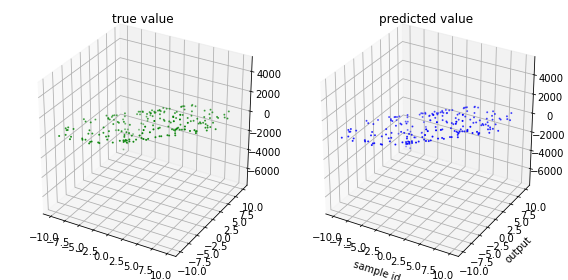

In [14]:
reg.compare_prediction(reg.predict(X_test), y_test, X_test)